In [1]:
import os
os.chdir('..')
from notebooks import config
import geopandas as gpd
import numpy as np
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.buffer_remove import buffer_remove
import matplotlib.pyplot as plt
from utils.transform_xy import coor2coor, imagexy2geo, geo2imagexy


In [2]:
path_vector = config.root_proj + '/data/tibet/tibet_tiles_vec/tibet_tiles.gpkg'
tiles_gdf = gpd.read_file(path_vector)
tiles_gdf.head()

/home/yons/miniconda3/envs/venv-luo/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,area,proj,tile_id,geometry
0,10852.910371,EPSG: 32646,001,"MULTIPOLYGON (((91.60292 25.97742, 91.60292 26..."
1,10856.066053,EPSG: 32646,002,"MULTIPOLYGON (((92.59904 25.97742, 92.59904 26..."
2,10853.222782,EPSG: 32647,003,"MULTIPOLYGON (((97.64819 25.97742, 97.64819 26..."
3,10856.025776,EPSG: 32647,004,"MULTIPOLYGON (((98.64468 25.97742, 98.64468 26..."
4,10850.995157,EPSG: 32647,005,"MULTIPOLYGON (((99.64905 25.97742, 99.64905 26..."


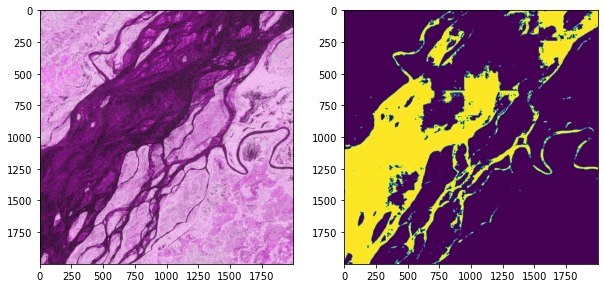

In [11]:
# ## check the prediction water map
# ## -- data path
tile_id = '012'
path_s1_img = config.root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water.tif'
## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)
## -- data visualization
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2)
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2)


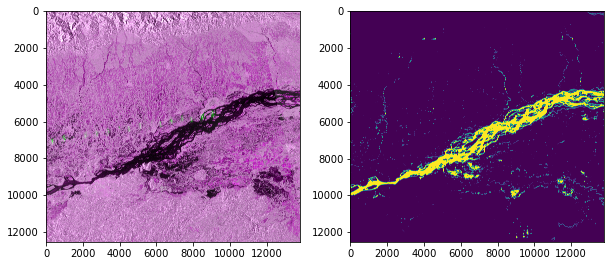

In [5]:
# ## check the prediction water map
# ## -- data path
tile_id = '001'
path_s1_img = config.root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water.tif'
## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)
## -- data visualization
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2)
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2)



## Remove the buffer region of the tile image

In [3]:
## remove the buffer region of tile
for tile_id in range(100, 103):   # !! tile_id start with 1
    tile_id = str(tile_id).zfill(3)
    print('tile subseting:', tile_id)
    path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water.tif'
    path_wat_subs = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif'
    ## get the idx of the tile vector
    idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
    tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds
    tile_region = (tile_region[0], tile_region[2], tile_region[1], tile_region[3]) # (left,right,down,up)
    img_subs, imgtrans_subs = buffer_remove(path_in=path_wat, \
                                path_out=path_wat_subs, extent=tile_region, save=True)



tile subseting: 100
tile subseting: 101
tile subseting: 102


## Check subseting of the image

In [24]:
## check
## -- data path
tile_id = '002'
path_s1_img = config.root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif'

## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)

## -- get tile region
idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds


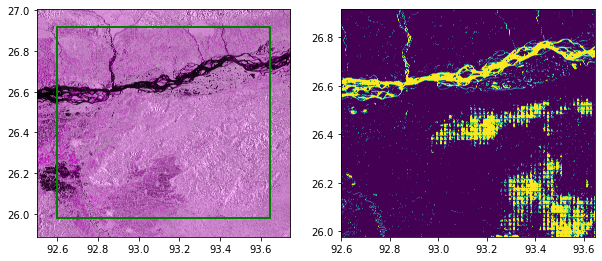

In [25]:
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, extent=s1_img_tile_info['geoextent'], color_bands=(0,1,0), clip_percent=2)
# outline
outline_x = [tile_region[0],tile_region[2], tile_region[2], tile_region[0],tile_region[0]]  
outline_y = [tile_region[1], tile_region[1], tile_region[3], tile_region[3], tile_region[1]]
plt.plot(outline_x, outline_y, color='g', linewidth=2)
## plot subsetted water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, extent=s1_tile_wat_info['geoextent'], color_bands=(0,1,0), clip_percent=2)



## Mosaic of the surface water maps

In [14]:
files = [
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_031_water_subs.tif', 
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_032_water_subs.tif', 
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_033_water_subs.tif', 
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_034_water_subs.tif', 
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_035_water_subs.tif', 
        config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_036_water_subs.tif', 
        ]

files_string = " ".join(files)
# print(files_string)
## excute
command = 'gdal_merge.py -o /mnt/data-tibet/tibet-202008/s1_water/tibet_tiles_water_mosaic.tif -init 0 ' + files_string
print(os.popen(command).read())


0...10...20...30...40...50...60...70...80...90...100 - done.



In [15]:
path_water_mosaic = config.root_tb_data + '/tibet-202008/s1_water/tibet_tiles_water_mosaic.tif'
wat_map_mosaic, wat_map_mosaic_info = readTiff(path_in = path_water_mosaic)


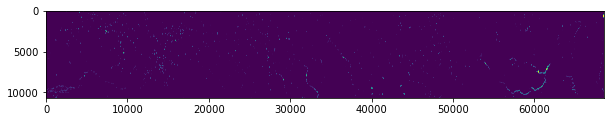

In [16]:
plt.figure(figsize=(10,5))
imgShow(wat_map_mosaic, color_bands=(0,1,0), clip_percent=2)
